## Description of the project:

   In this part of the class, we will curate a set of **CO2 measurements**, measured from cheap but inaccurate sensors, that have been deployed in the city of Zurich. The goal of the exercise is twofold: 

1. Learn how to deal with real world sensor timeseries data, and organize them efficiently using python dataframes.

2. Apply data science tools to model the measurements, and use the learned model to process them (e.g., detect outliers and drifts in the sensor measurements). 

The sensor network consists of 46 sites, located in different parts of the city. Each site contains three different sensors measuring (a) **CO2 concentration**, (b) **temperature**, and (c) **humidity**. Beside these measurements, we have the following additional information that can be used to process the measurements: 


1. The average **daily wind pattern** for the city of Zurich 

2. The **altitude** at which the CO2 sensor is located

3. A clustering of the city of Zurich in 17 different zones and the **city zone** in which the sensor belongs to. Some characteristic zones are industrial area, residential area, forest, glacier, lake, etc.

Given this knowledge, you are asked to define a machine learning algorithm that curates the data, by detecting potential outliers or drifts. The algorithm should be based on the fact that sensors in similar conditions are expected to have similar measurements.

## Prior knowledge:
    
The average value of the CO2 in a city is approximately 400 ppm. However, the exact measurement in each site depends on parameters such as the temperature, the humidity, the wind, the altitude, and the level of traffic around the site. For example, sensors positioned in high altitude (mountains) and exposed to stronger winds, are expected to have a much lower and uniform level of CO2 than sensors that are positioned in a business area with much higher traffic activity. Moreover, we know that there is a strong dependence of the CO2 measurements, on temperature and humidity.



## Goal:
    
  We would like to use the above knowledge in order to fit a robust regression model to the CO2 measurements. This model should be built by processing the measurements of the entire sensor network jointly, and it should take into account the dependence on the above mentioned parameters. Finally, the learned model will be used to curate the CO2 measurements by detecting possible outliers and drifts. 

**Note:**
Different machine learning approaches can be used to solve the problem. For simplicity, we provide a suggested approach, and the corresponding steps that can guide your solution. 


### Imports

Import the following python packages: pandas, datetime, matplotlib, numpy, sklearn

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import sklearn
import array
import warnings
import random
warnings.filterwarnings('ignore')

### To start with: 

The following csv files will be needed: 

- `CO2_sensor_measurements.csv`

Description: It containts the CO2 measurements (CO2), the name of the site (LocationName), a unique sensor identifier (SensorUnit_ID), and the time instance in which the measurement was taken (timestamp).
    
- `temperature_humidity.csv`

Description: It contains the temperature and the humidity measurements for each sensor identifier, at each timestamp (Timestamp). For each SensorUnit_ID, the temperature and the humidity can be found in the corresponding columns of the dataframe (SensorUnit_ID.temperature, SensorUnit_ID.humidity).
    
- `sensor_metadata.csv`

Description: It contains the name of the site (LocationName), the zone index (zone), and the altitude in meters. 
    
- `zurich_average_wind.csv`

Description: It contains the average wind speed (wind_speed) in the city of Zurich measured every 30 minutes (timestamp).

In [2]:
CO2_measurement = pd.read_csv('CO2_sensor_measurements.csv', sep='\t')
zurich_average_wind = pd.read_csv('zurich_average_wind.csv', sep='\t')
zurich_temp_humidity= pd.read_csv('temperature_humidity.csv', sep='\t')
sensors_metadata = pd.read_csv('sensors_metadata.csv', sep='\t') 


## PART I: Handling time series with pandas (15 points)

### Question I.a. (12/15)

Organize the CO2_sensor_measurements.csv and temperature_humidity.csv files into a single dataframe that contains as index the time instance (timestamp) of the measurements, and columns the location of the site (LocationName), the sensor ID (SensorUnit_ID), the CO2 measurement, the temperature, and the humidity. For each measurement (CO2, humidity, temperature), take the average over an interval of 30 min. If there are missing measurements, interpolate them linearly from measurements that are close by in time.

Hints: the following methods could be useful:

- [pandas.DataFrame.resample()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html)
    
- [pandas.DataFrame.interpolate()](https://pandas.pydata.org/pandasdocs/stable/generated/pandas.DataFrame.interpolate.html)

- [pandas.DataFrame.mean()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.mean.html)

- [pandas.DataFrame.append()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.append.html)

In [3]:
CO2_measurement.head()

,timestamp,LocationName,SensorUnit_ID,CO2
0,2017-10-01 00:05:00,ZGHD,1014,593.321562
1,2017-10-01 00:15:00,ZGHD,1014,595.846258
2,2017-10-01 00:25:00,ZGHD,1014,595.845353
3,2017-10-01 00:45:00,ZGHD,1014,599.039129
4,2017-10-01 00:55:00,ZGHD,1014,594.996629


In [4]:
# Here we convert the index into a 'datetime' object, then group by time and downsample to 30mn and take the mean
co2 = CO2_measurement.copy()
co2.index = pd.to_datetime(co2['timestamp'])
co2.drop(columns='timestamp', inplace=True)
co2 = co2.groupby('SensorUnit_ID').resample('30Min').mean()
co2 = co2.interpolate()
# Put the SensorUnit_IDs labels back 
locations = CO2_measurement['LocationName'].unique()
ids = CO2_measurement['SensorUnit_ID'].unique()
mapping = dict(zip(ids, locations))
co2['LocationName'] = co2.SensorUnit_ID.map(mapping)

In [5]:
# convert index into datetime
temp_hum = zurich_temp_humidity.copy()
temp_hum.index = pd.to_datetime(temp_hum['Timestamp'])
temp_hum.drop(columns='Timestamp', inplace=True)

In [6]:
#interpolate all the missing values:
col = temp_hum.columns
temp_hum = temp_hum.resample('30Min').mean()
temp_hum = temp_hum.interpolate()

In [7]:
# splitting into separate dataframes 
dfs = []
for i in range(0, len(col), 2):
    dfs.append(temp_hum.iloc[:,i:i+2])
    current_id = (temp_hum.columns)[i].split('.')[0]

In [8]:
# labelling the sensor unit
for df in dfs:
    sensor_id = (df.columns)[0].split('.')[0]
    df['SensorUnit_ID'] = sensor_id

# renaming the columns
for df in dfs:
    df.rename(columns={df.columns[0]: 'temperature', df.columns[1]: 'humidity'}, inplace=True)

In [9]:
# resample each one of the dataframes, each containing data (temperature and humidity) from a different sensor
for i in range(len(dfs)):
    dfs[i] = dfs[i].groupby('SensorUnit_ID').resample('30Min').mean()

In [10]:
# concatenate all the dataframes into a single one, as done earlier with the CO2 data
t_h = pd.DataFrame()
for df in dfs:
    t_h = pd.concat([t_h, df])   
# We are now ready to merge the 2 dataframes

In [11]:
t_h['SensorUnit_ID'] = t_h.index.get_level_values(0)
t_h.index = t_h.index.droplevel()
co2.index = co2.index.droplevel()
display(t_h.head())
display(co2.head())

,temperature,humidity,SensorUnit_ID
Timestamp,,,
2017-10-01 00:00:00,11.396667,92.440806,1014
2017-10-01 00:30:00,11.325000,91.770691,1014
2017-10-01 01:00:00,11.240000,91.096761,1014
2017-10-01 01:30:00,11.260000,91.275734,1014
2017-10-01 02:00:00,11.290000,91.061157,1014


,SensorUnit_ID,CO2,LocationName
timestamp,,,
2017-10-01 00:00:00,1014.0,595.004391,ZGHD
2017-10-01 00:30:00,1014.0,597.017879,ZGHD
2017-10-01 01:00:00,1014.0,596.487010,ZGHD
2017-10-01 01:30:00,1014.0,598.787639,ZGHD
2017-10-01 02:00:00,1014.0,595.366394,ZGHD


In [12]:
t_h.reset_index(inplace=True)
co2.reset_index(inplace=True)

In [13]:
t_h.rename(columns={'Timestamp' : 'timestamp'}, inplace=True)

In [14]:
# Now that both our dataframes are clean, we are ready to merge them and rename the columns
merged = pd.merge(co2, t_h, on=['timestamp'],how='inner',left_index= True, right_index= True, sort=True)
merged.set_index('timestamp', inplace=True)
merged.drop(columns=['SensorUnit_ID_x'], inplace=True)
merged.rename(columns={'SensorUnit_ID_y':'SensorUnit_ID'}, inplace=True)
merged = merged[['CO2', 'LocationName', 'SensorUnit_ID', 'temperature', 'humidity']]
merged.head()

,CO2,LocationName,SensorUnit_ID,temperature,humidity
timestamp,,,,,
2017-10-01 00:00:00,595.004391,ZGHD,1014,11.396667,92.440806
2017-10-01 00:30:00,597.017879,ZGHD,1014,11.325000,91.770691
2017-10-01 01:00:00,596.487010,ZGHD,1014,11.240000,91.096761
2017-10-01 01:30:00,598.787639,ZGHD,1014,11.260000,91.275734
2017-10-01 02:00:00,595.366394,ZGHD,1014,11.290000,91.061157


Hint: Your dataframe should look like that

In [15]:
pd.read_csv('Hint_Ia.csv', index_col='Unnamed: 0')

,CO2,LocationName,SensorUnit_ID,temperature,humidity
2017-10-01 00:00:00,595.004391,ZGHD,1014,11.396667,92.440806
2017-10-01 00:30:00,597.017879,ZGHD,1014,11.325000,91.770691
2017-10-01 01:00:00,596.487010,ZGHD,1014,11.240000,91.096761
2017-10-01 01:30:00,598.787639,ZGHD,1014,11.260000,91.275734
2017-10-01 02:00:00,595.366394,ZGHD,1014,11.290000,91.061157


### Question I.b. (3/15)

Export the curated and ready to use timeseries to a csv file. 

In [16]:
merged.to_csv('merged_data.csv')

## PART II: Finding meaningful structures/patterns in the data (20 points)

### Question II.a. (3/30)

Plot the daily median CO2 measurement for each site with respect to the altitude. Annotate each point of the plot with the name of the location (LocatioName).

In [17]:
metadata = sensors_metadata.set_index('LocationName')

In [18]:
location = merged.join(metadata, on= 'LocationName').set_index('altitude')

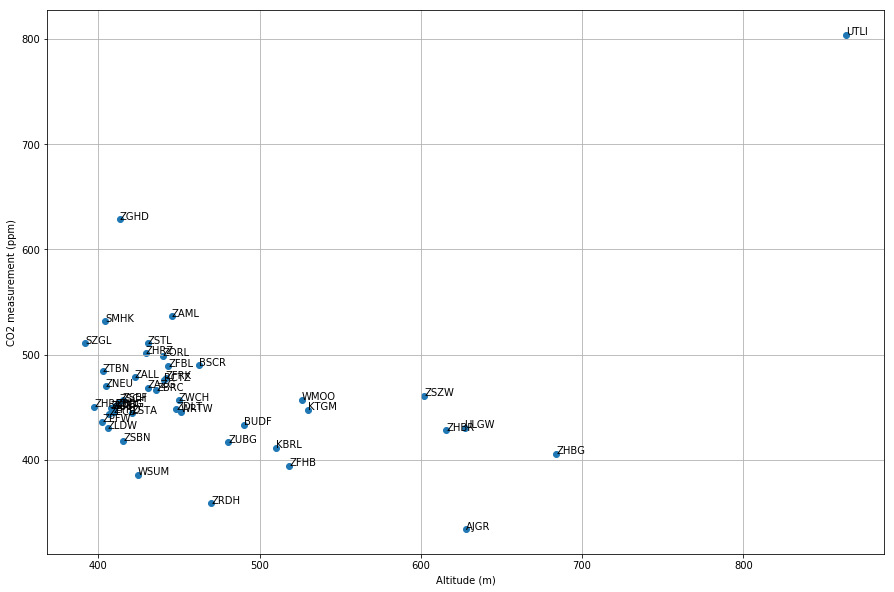

In [19]:
a = merged.join(metadata, on= 'LocationName').groupby('LocationName').resample('1D').median()
a = a.groupby('altitude').mean()
a['altitude'] = a.index
carbon = list(a.CO2)
alt = list(a.altitude)
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
plt.grid()
plt.xlabel('Altitude (m)')
plt.ylabel('CO2 measurement (ppm)')
plt.scatter(alt, carbon)
for p in list(zip(alt, carbon)):
    loc = location.loc[p[0]].iloc[0].LocationName
    #print(loc)
    ax.annotate('%s' % loc, xy=p)
plt.show()

### Question II.b. (7/20)

**Altitude clustering:** Cluster the sites based on their altitude, by performing a K-means clustering. Set the number of clusters to 4. 

In [20]:
from sklearn import cluster

In [21]:
X = metadata.altitude.reshape(-1, 1)
kmeans = cluster.KMeans(n_clusters=4).fit(X)

In [22]:
# Below are the sensors, along with their altitude clusters
clustered_data = list(zip(list(sensors_metadata.LocationName), kmeans.labels_))
sorted(clustered_data, key= lambda x: x[1])

[('BSCR', 0),
 ('BUDF', 0),
 ('KBRL', 0),
 ('KTGM', 0),
 ('WMOO', 0),
 ('ZFHB', 0),
 ('ZRDH', 0),
 ('ZUBG', 0),
 ('AJGR', 1),
 ('ULGW', 1),
 ('ZHBG', 1),
 ('ZHBR', 1),
 ('ZSZW', 1),
 ('RCTZ', 2),
 ('SMHK', 2),
 ('SZGL', 2),
 ('WRTW', 2),
 ('WSUM', 2),
 ('ZALL', 2),
 ('ZAML', 2),
 ('ZAZG', 2),
 ('ZBLG', 2),
 ('ZBRC', 2),
 ('ZDLT', 2),
 ('ZECB', 2),
 ('ZFBL', 2),
 ('ZFRK', 2),
 ('ZGHD', 2),
 ('ZHRG', 2),
 ('ZHRO', 2),
 ('ZHRZ', 2),
 ('ZLDW', 2),
 ('ZLMT', 2),
 ('ZNEU', 2),
 ('ZORL', 2),
 ('ZPFW', 2),
 ('ZPRD', 2),
 ('ZSBN', 2),
 ('ZSCH', 2),
 ('ZSEF', 2),
 ('ZSTA', 2),
 ('ZSTL', 2),
 ('ZTBN', 2),
 ('ZUE', 2),
 ('ZWCH', 2),
 ('UTLI', 3)]

### Question II.c. (7/20)

**Temporal clustering:** Cluster the days of the month based on the average wind conditions of the city of Zurich. 

First, resample the daily wind signal by computing the mean over an interval of 30 min. 

Then, consider each day as a 48-dimensional sample (30 min intervals per day). Perform a principle component analysis of the wind values to reduce the dimension to 2.  
Hint: You can use `pandas.DataFrame.grouby()` and `for` to generate the daily sample ([documentation](https://pandas.pydata.org/pandas-docs/stable/groupby.html#iterating-through-groups)).

Finally, apply K-means to the first two PCA coefficients. Set the number of clusters to 6.

In [23]:
# transform the date index into 'timestamp'
zurich_average_wind.index = pd.to_datetime(zurich_average_wind['timestamp'])
wind_per_day = []
dates = []
for date, group in zurich_average_wind.groupby(pd.TimeGrouper('D')):
    dates.append(date)
    wind_per_day.append(np.array(group.wind_speed))

In [24]:
X = np.asarray(wind_per_day)
Y = np.array(range(30))

In [25]:
# Perform a PCA analysis with 2 components
pca = sklearn.decomposition.PCA(n_components=2)
principalComponents = pca.fit_transform(X)
pca_components = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
pca_components.index = pca_components.index.map(lambda x: x+1)
pca_components.head()

,principal component 1,principal component 2
1,-4.106523,-1.663550
2,-0.869377,4.207631
3,8.023951,-8.309913
4,-3.281485,-0.074907
5,8.288445,11.560985


In [26]:
kmean_pca = cluster.KMeans(n_clusters=6).fit(pca_components)

In [27]:
print('K-means to the first two PCA coefficients, using 6 clusters :')
print('-------------------------------------------------------------')
clusters = {i: 1 + np.where(kmean_pca.labels_ == i)[0] for i in range(kmean_pca.n_clusters)}
for i in range(6):
    print('Cluster {} = {}'.format(i, clusters[i]))

K-means to the first two PCA coefficients, using 6 clusters :
-------------------------------------------------------------
Cluster 0 = [ 1  9 13 14 15 16 17 18 19 24 25 26]
Cluster 1 = [ 3  8 23]
Cluster 2 = [ 5 21 28]
Cluster 3 = [22 29]
Cluster 4 = [ 6 12 27 30]
Cluster 5 = [ 2  4  7 10 11 20 31]


### Question II.d. (3/20)

Choose one of the wind clusters, and plot the average wind of the days corresponding to that cluster. 

**We decided to choose the first cluster**

In [28]:
clusters[0]

array([ 1,  9, 13, 14, 15, 16, 17, 18, 19, 24, 25, 26])

In [29]:
# We choose the cluster 0
def plot_cluster(i):    
    clusters_means = []
    for a in clusters[i]:
        clusters_means.append(np.mean(wind_per_day[a-1]))
        
    plt.figure(figsize=(14,6))    
    plt.plot([dates[i] for i in (clusters[i] - 1)], clusters_means, '-o')
    plt.title('Average wind of the days belonging to cluster {}'.format(i))
    plt.xlabel('Date')
    plt.ylabel('Wind speed')
    plt.grid()
    plt.show()

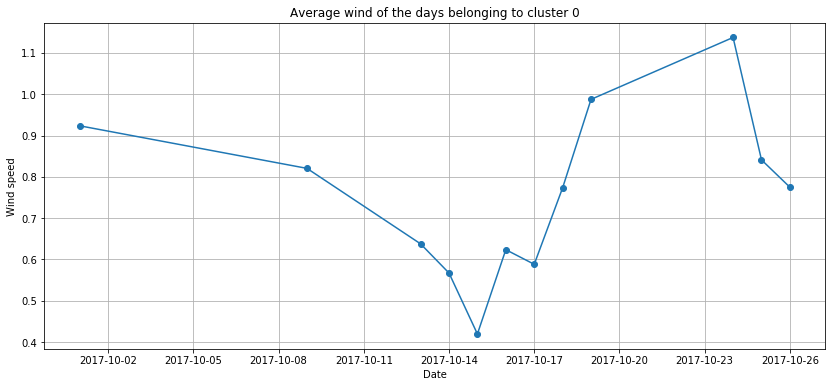

In [30]:
plot_cluster(0)

## PART III: Model fitting for outlier detection (15 points)


### Question III.a.(5/15)

A domain expert indicates that there is problem with the `ZSBN` sensor, which appears after October 24. You decide to fit a linear model to the CO2 measurements of the site, by considering as features the temperature and the humidity. Plot and compare the actual CO2 measurements, and the values obtained by the prediction of the linear model for the entire month of October. Can you guess the problem from your plot?

In [31]:
# Extract the ZSBN data
features = merged.copy()
features['timestamp'] = features.index
features = features.set_index(features.LocationName).loc['ZSBN']

In [32]:
features.head()

,CO2,LocationName,SensorUnit_ID,temperature,humidity,timestamp
LocationName,,,,,,
ZSBN,418.493079,ZSBN,1031,11.146667,92.608017,2017-10-01 00:00:00
ZSBN,418.169200,ZSBN,1031,10.915000,92.220825,2017-10-01 00:30:00
ZSBN,421.749522,ZSBN,1031,10.860000,92.662059,2017-10-01 01:00:00
ZSBN,424.363039,ZSBN,1031,10.820000,92.934809,2017-10-01 01:30:00
ZSBN,423.172512,ZSBN,1031,10.760000,93.407832,2017-10-01 02:00:00


In [33]:
# We regress the CO2 on both temperature and humidity
linreg = sklearn.linear_model.LinearRegression()
x = np.asarray(features[['temperature', 'humidity']])
y = np.asarray(features['CO2'])
linreg.fit(x, y)
y_pred = linreg.predict(x)
features['y_pred'] = y_pred

In [34]:
# Add the predictions into our dataframe
features.set_index('timestamp', inplace=True)
features.head()

,CO2,LocationName,SensorUnit_ID,temperature,humidity,y_pred
timestamp,,,,,,
2017-10-01 00:00:00,418.493079,ZSBN,1031,11.146667,92.608017,457.938679
2017-10-01 00:30:00,418.169200,ZSBN,1031,10.915000,92.220825,454.637295
2017-10-01 01:00:00,421.749522,ZSBN,1031,10.860000,92.662059,455.866689
2017-10-01 01:30:00,424.363039,ZSBN,1031,10.820000,92.934809,456.578996
2017-10-01 02:00:00,423.172512,ZSBN,1031,10.760000,93.407832,457.888726


In [35]:
features['timestamp'] = features.index

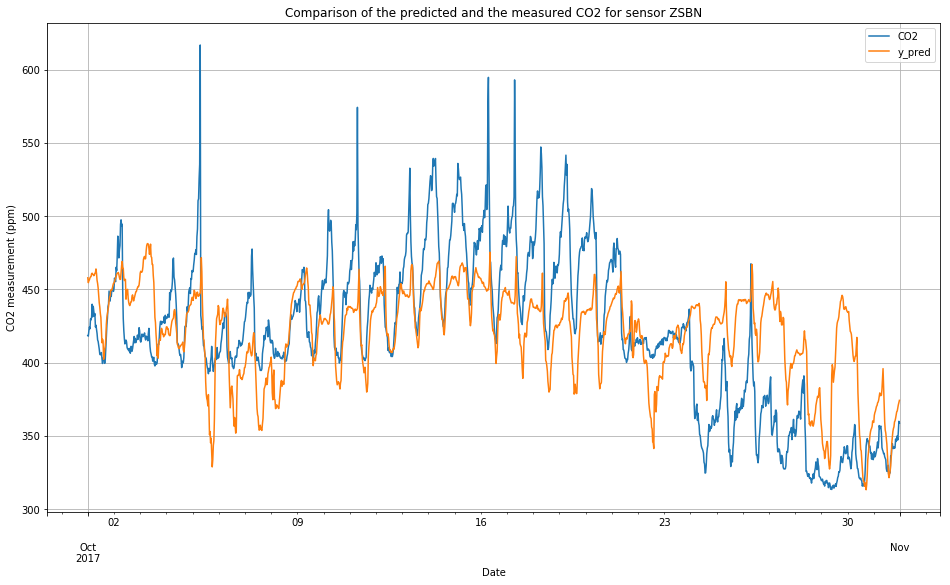

In [36]:
# Plot the predicted and the measured CO2

features[['CO2', 'y_pred']].plot(figsize=(16,9))
plt.ylabel('CO2 measurement (ppm)')
plt.xlabel('Date')
plt.title('Comparison of the predicted and the measured CO2 for sensor ZSBN')
plt.grid()
plt.show()

#### We clearly notice the drift on October 24th on the above graph, which is due to a problem with the ZBSN sensor.

### Question III.b. (8/15)

In your next attempt to find the problem, you decide to use the temporal and altitude clusters computed in PART II, together with the zone clusters of the city that are already provided, to improve your model. 

First, find the sensors belonging to the same zone and altitude cluster. Keep only the part of the dataframe from Part I.a that matches the same zone and altitude cluster with `ZSBN`.

Then, partition the obtained dataframe into six parts, each corresponding to one of the wind clusters.  

Use the partitioned dataframes to learn a new regression model for each of them. For each linear model, use as features 1) the temperature, 2) the humidity, and 3) the time of the day measured in the range between 0 and 47 (intervals of 30 min). At the end of this step, you should have obtained a simple linear regression model for each wind cluster.

Finally, plot and compare the actual CO2 measurements, and the values obtained by the linear model for the entire month of October. If all the steps are done correcly, you should be able to clearly detect the drift observed after October 26th.

In [37]:
# create a mapping between the days of the month and the labels from clustering the PCA components of the wind
wind_mapping = list(zip(range(1, 32), kmean_pca.labels_))
wind_mapping = sorted(wind_mapping, key= lambda x: x[0])

In [38]:
final = merged.copy().join(metadata, on= 'LocationName')
final['timestamp'] = final.index

In [39]:
# map the days of the month to their respective wind clusters
final['wind_cluster'] = final.index.map(lambda x: wind_mapping[x.day - 1][1])

In [40]:
# create categorical variables that maps the time of the day to in a range between 0 and 47 (intervals of 30 min) 
time_of_day = final.timestamp.apply(lambda x: str(x).split(' ')[1]).astype('category').cat.codes
final['time_of_day'] = time_of_day

In [41]:
# map each location name to the corresponding altitude cluster
final['altitude_cluster'] = final.LocationName.map(lambda x: dict(clustered_data)[x])
final.head(3)

,CO2,LocationName,SensorUnit_ID,temperature,humidity,zone,altitude,timestamp,wind_cluster,time_of_day,altitude_cluster
timestamp,,,,,,,,,,,
2017-10-01 00:00:00,595.004391,ZGHD,1014,11.396667,92.440806,2.0,413.5,2017-10-01 00:00:00,0,0,2
2017-10-01 00:30:00,597.017879,ZGHD,1014,11.325000,91.770691,2.0,413.5,2017-10-01 00:30:00,0,1,2
2017-10-01 01:00:00,596.487010,ZGHD,1014,11.240000,91.096761,2.0,413.5,2017-10-01 01:00:00,0,2,2


**Keep only the part of the dataframe that matches the same: zone and altitude cluster with ZSBN:**

In [42]:
# 1. zone cluster with ZBSN
zone_zsbn = list(set(final.set_index('LocationName').loc['ZSBN'].zone))[0]
zone_zsbn

3.0

In [43]:
# 2. altitude cluster with ZBSN
alt_cluster_zbsn = list(set(final.set_index('LocationName').loc['ZSBN'].altitude_cluster))[0]
alt_cluster_zbsn

2

In [44]:
# Keep only the part of the dataframe from Part I.a that matches the same zone and altitude cluster with ZSBN
to_partition = final[(final.zone == zone_zsbn) & (final.altitude_cluster == alt_cluster_zbsn) & (final.LocationName != 'ZSBN')]

### Partition into six dataframes

In [45]:
# Partition the data by wind cluster
partitions = []
for i in range(6):
    partitions.append(to_partition[to_partition.wind_cluster == i])

In [46]:
# Apply a linear regression to each of the six parts
for i in range(6):
    linreg = sklearn.linear_model.LinearRegression()
    x = np.asarray(partitions[i][['temperature', 'humidity', 'time_of_day']])
    y = np.asarray(partitions[i]['CO2'])
    linreg.fit(x, y)    
    y_pred = linreg.predict(x)
    partitions[i]['CO2_pred'] = y_pred

In [47]:
# Collecting the data altogether, i.e. concatenating all the six parts
df = pd.DataFrame()
for p in partitions:
    df = pd.concat([df, p])
    
d = df.copy()
d = d.groupby('timestamp').mean()
d['timestamp'] = d.index

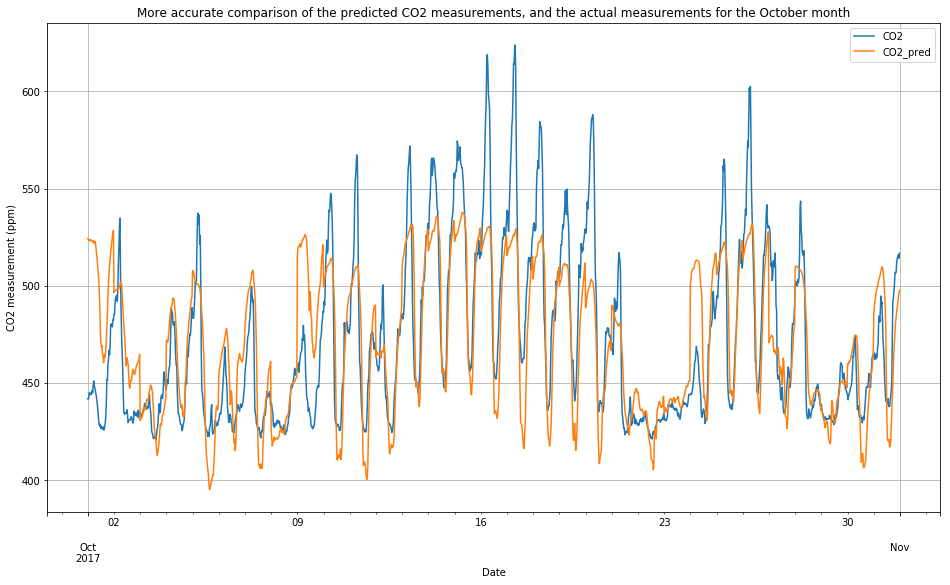

In [48]:
# Plotting the results 
d[['CO2', 'CO2_pred']].plot(figsize=(16,9))
plt.ylabel('CO2 measurement (ppm)')
plt.xlabel('Date')
plt.title('More accurate comparison of the predicted CO2 measurements, and the actual measurements for the October month')
plt.grid()
plt.show()

### Question III.c. (2/15)

Focus on the `KBRL` site. Apply the same procedure by fitting a linear model to the days with similar wind behavior. Plot and compare the actual CO2 measurements, and the values obtained by the linear model for the entire month of October. If all the steps are done correcly, you should be able detect the outlier observed in the beginning of October.

In [49]:
# Take the data from the KBRL site and partition it according to the wind clusters
kbrl = final.set_index('LocationName').loc['KBRL'].set_index('timestamp')
kbrl_partitions = []
for i in range(6):
    kbrl_partitions.append(kbrl[kbrl.wind_cluster == i])

In [50]:
# Apply a linear regression to each of the 6 dataframes, as we did earlier
for i in range(6):
    linreg = sklearn.linear_model.LinearRegression()
    x = np.asarray(kbrl_partitions[i][['temperature', 'humidity', 'time_of_day']])
    y = np.asarray(kbrl_partitions[i]['CO2'])
    linreg.fit(x, y)    
    y_pred = linreg.predict(x)
    kbrl_partitions[i]['CO2_pred'] = y_pred

In [51]:
# Collecting the data altogether, i.e. concatenating all the six parts
kbrl_pred = pd.DataFrame()
for p in kbrl_partitions:
    kbrl_pred = pd.concat([kbrl_pred, p])

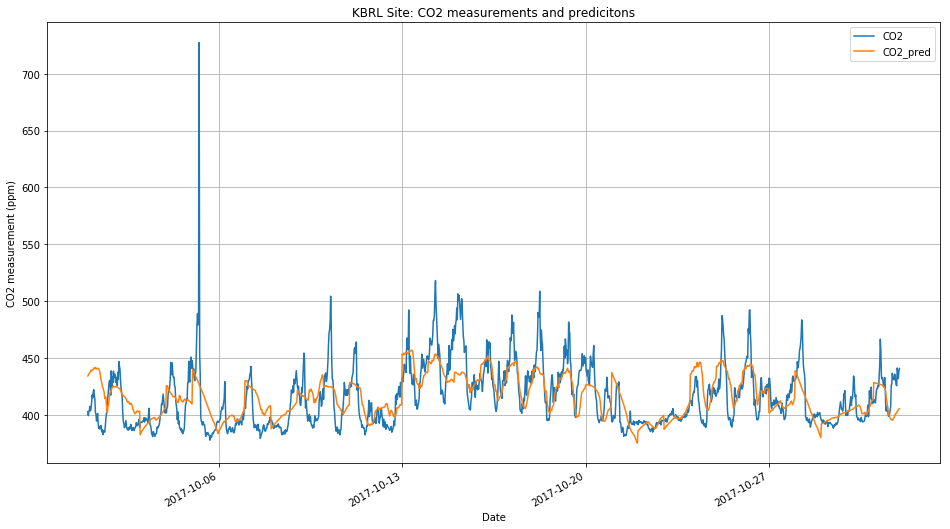

In [52]:
# Plot the predictions
kbrl_pred[['CO2', 'CO2_pred']].plot(figsize=(16,9))
plt.ylabel('CO2 measurement (ppm)')
plt.xlabel('Date')
plt.title('KBRL Site: CO2 measurements and predicitons')
plt.grid()
plt.show()

### We can clearly see the outlier at the beginning of the month of October.

## PART IV: Share your work with the domain expert (10 points)

The domain experts would like to try out your work but they have python 2.6 installed and they
do not want to install anaconda3.
They tried to create a `Dockerfile` in order to build a Docker image and play with the notebook
but it didn't work.

Use
```bash
docker build -t co2notebook .
```
and
```bash
docker run --init --rm -it -p 8888:8888 co2notebook
```
to play with the Docker image.
More details can be found in the README file.

Notice how the notebook opens but that the first code cell cannot be executed.
```
---------------------------------------------------------------------------
ModuleNotFoundError                       Traceback (most recent call last)
[...]
```

### Question IV.a. (10/10)

Edit the `Dockerfile` so that you can execute the whole notebook from the `docker run` command.
This means that all the cells should run, not just the first one.

While this task can be completed by minor modifications, you are free to edit any part of the `Dockerfile`.

For a complete read over how a `Dockerfile` works, head to https://docs.docker.com/engine/reference/builder/.